In [2]:
import numpy as np
from numpy.linalg import norm
from numpy.random import normal
from scipy.optimize import minimize, Bounds, least_squares
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Исходные данные

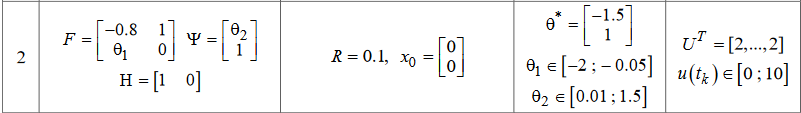

In [316]:
def F_(th_1: float) -> np.matrix:
    return np.matrix([[-0.8, 1], [th_1, 0]])

def Psi_(th_2: float) -> np.matrix:
    return np.matrix([[th_2], [1]])

G = np.matrix([1, 1]).T
H: np.matrix = np.matrix([[1, 0]])
R: np.ndarray = np.array([[0.1]])
Q = np.matrix(0.1)
x_0: np.matrix = np.matrix([[0], [0]])
th_true: np.ndarray = np.array([-0.01, 1])
th_1_range: list = [-0.05, 0]
th_2_range: list = [0.01, 1.5]

u_tk: np.matrix = np.matrix([[1]])

N: int = 30  # Размерность сигнала U
s: int = 2  # Размерность th 

U: np.matrix = np.matrix(np.ones(N+1)*2).T

In [317]:
np.linalg.eig(F_(th_true[0]))[0]

array([-0.78729833, -0.01270167])

# 2. Отклик

In [263]:
def gen_XY(th: np.ndarray, err=1, err2=1):
    X: np.matrix = np.matrix(np.zeros((2, N+1)))
    Y: np.matrix = np.matrix(np.zeros((N+1, 1)))
    F: np.matrix = F_(th[0])
    Psi: np.matrix = Psi_(th[1])
    X[:, 0] = x_0
    Y[0] = H @ X[:, 0] + normal(-np.sqrt(R)/2, np.sqrt(R))*err
    for k in range(1, N+1):
        wi = normal(-np.sqrt(R)/2, np.sqrt(Q), (1,2))*err
        vi = normal(-np.sqrt(Q)/2, np.sqrt(R))*err*err2
        X[:, k] = F @ X[:, k-1] + Psi @ U[k] + (G @ wi)[0].T
        Y[k] = H @ X[:, k] + vi
    return X, Y

X, Y = gen_XY(th_true)

In [318]:
def gen_XY(th: np.ndarray, err=1, err2=1):
    X: np.matrix = np.matrix(np.zeros((2, N+1)))
    Y: np.matrix = np.matrix(np.zeros((N+1, 1)))
    F: np.matrix = F_(th[0])
    Psi: np.matrix = Psi_(th[1])
    X[:, 0] = x_0
    Y[0] = H @ X[:, 0] + normal(-np.sqrt(R)/2, np.sqrt(R))*err
    for k in range(1, N+1):
        wi = normal(-np.sqrt(R)/2, np.sqrt(Q), (1,2))*err
        vi = normal(-np.sqrt(Q)/2, np.sqrt(R))*err*err2
        X[:, k] = F @ X[:, k-1] + Psi @ U[k]
        Y[k] = H @ X[:, k] + vi
    return X, Y

X, Y = gen_XY(th_true)

# 3. Критерий идентификации

In [319]:
def Hi(th: np.ndarray, Y: np.ndarray) -> float:
    m: int = 1
    v: int = 1
    F: np.matrix = F_(th[0])
    Psi: np.matrix = Psi_(th[1])
    
    Hi: float = N * m * np.log(2 * np.pi) + N * v * np.log(np.linalg.det(R))
    x_k: np.ndarray = x_0
    
    for k in range(N):
        x_k_k: np.ndarray = F @ x_k + Psi @ u_tk
        epsilon: np.ndarray = Y[k + 1] - H @ x_k_k
        delta = epsilon.T @ np.linalg.inv(R) @ epsilon
        Hi += delta
    return 0.5 * Hi

Hi(th_true, Y)

matrix([[150.99201716]])

# 4. Градиент критерия

In [320]:
def gradHi(th: np.ndarray, Y: np.ndarray) -> float:
    dF: list[np.matrix, np.matrix] = [np.matrix([[0, 0], [0, 0]]), np.matrix([[0, 0], [1, 0]])]
    dPsi: list[np.matrix, np.matrix] = [np.matrix([[0], [0]]), np.matrix([[1], [0]])]
    dx_0: list[np.matrix, np.matrix] = [np.matrix([[0], [0]]), np.matrix([[0], [0]])]

    v: int = 1
    F: np.matrix = F_(th[0])
    Psi: np.matrix = Psi_(th[1])

    gradHi: np.ndarray = np.zeros(len(th))
    x_k: np.ndarray = x_0
    dx_k: list[np.matrix, np.matrix] = dx_0
    delta = np.zeros((s, 1))
    R_inv = np.linalg.inv(R)
    
    for k in range(N):
        x_k_k: np.ndarray = F @ x_k + Psi @ u_tk
        
        dx_k_k: list = [None, None]
        dEpsilon: list = [None, None]
        
        for i in range(s):
            dx_k_k[i]: np.matrix = dF[i] @ x_k + F @ dx_k[i] + dPsi[i] @ u_tk
            dEpsilon[i]: np.matrix = - H @ dx_k_k[i]
            epsilon: np.ndarray = Y[k + 1] - H @ x_k_k
            delta[i] += (dEpsilon[i].T @ np.linalg.inv(R) @ epsilon).item()
            gradHi[i] += delta[i].item()
        
    return gradHi

In [321]:
gradHi(th_true, Y)

array([    0.        , -4757.23453875])

# 5. Подбор параметров

In [322]:
th_est_m0 = []
th_est_m1 = []

Y_observation_list = []
res_0_x = []
res_1_x = []

for i in range(5):
    _, Y_obs = gen_XY(th_true)
    Y_observation_list.append(Y_obs)
    th_0 = np.array([np.random.uniform(-0.05, 0), np.random.uniform(0.01, 1.5)])

    res_0 = minimize(
    method="nelder-mead",
    fun=Hi,
    x0=th_0,
    bounds=Bounds([-0.05, 0], [0.01, 1.5]),
    options={"xatol": 1e-5, "fatol": 1e-5},
    tol=1e-5,
    args=(Y_obs, ),
    )
    res_0_x.append(res_0.x)
    res_1 = minimize(
    method="SLSQP",
    fun=Hi,
    x0=th_0,
    jac=gradHi,
    bounds=Bounds([-0.05, 0], [0.01, 1.5]),
    options={"eps": 1e-12, "ftol": 1e-12},
    tol=1e-12,
    args=(Y_obs, ),
    )
    res_1_x.append(res_1.x)
res_0_x = np.array(res_0_x)
res_1_x = np.array(res_1_x)
print(res_0_x, res_1_x)

[[ 1.00000000e-02  1.50000000e+00]
 [-6.12445966e-03  1.50000000e+00]
 [ 6.15653145e-04  1.50000000e+00]
 [-2.73201445e-04  1.50000000e+00]
 [-1.98789560e-02  1.50000000e+00]] [[-4.80932110e-02  3.98806472e-01]
 [-7.20524666e-03  1.18855507e+00]
 [-6.35512924e-03  6.13301517e-01]
 [-4.28551287e-04  1.02221521e+00]
 [-4.41754578e-02  9.00274918e-01]]


In [323]:
#print(f"th0: {th_0}\tМ0: {res_0['x']} ({res_0['nit']}/{res_0['nfev']})\
#М1: {res_1['x']} ({res_1['nfev']}/{res_1['njev']}/{res_1['nit']})
#th_est_m0.append(res_0['x'])
#th_est_m1.append(res_1['x'])
th_est_m0 = res_0_x
th_est_m1 = res_1_x

In [324]:
th_est_m0 = np.mean(th_est_m0[:, 0]), np.mean(th_est_m0[:, 1])
th_est_m1 = np.mean(th_est_m1[:, 0]), np.mean(th_est_m1[:, 1])
print(f"Среднее по 5 наблюдениям\nM0: {th_est_m0}\nM1: {th_est_m1}")

Среднее по 5 наблюдениям
M0: (-0.003132192792716684, 1.5)
M1: (-0.021251519193748604, 0.8246306370288728)


In [325]:
def mean(th):
    Y_ = np.array([gen_XY(th, 1, 0)[1] for _ in range(100)])
    return np.array([np.mean(np.array(Y_)[:, i]) for i in range(N+1)]).reshape(N+1)
Y_mean_obs = np.array([np.mean(np.array(Y_observation_list)[:, i]) for i in range(N+1)])
Y_est_m0 = mean(th_est_m0)
Y_est_m1 = mean(th_est_m1)

In [326]:
Y_est_m0

array([-0.19991434,  3.        ,  2.6       ,  2.91060342,  2.66337356,
        2.86018458,  2.70351014,  2.82823324,  2.72894549,  2.80798503,
        2.74506439,  2.79515334,  2.75527926,  2.78702163,  2.76175263,
        2.78186841,  2.76585493,  2.77860271,  2.76845464,  2.77653317,
        2.77010213,  2.77522166,  2.77114618,  2.77439053,  2.77180782,
        2.77386382,  2.77222711,  2.77353004,  2.77249282,  2.77331851,
        2.77266121])

In [327]:
dth_m0 = norm(th_true - th_est_m0) / norm(th_true)
dY_m0 = norm(Y_mean_obs - Y_est_m0) / norm(Y_mean_obs)
dth_m1 = norm(th_true - th_est_m1) / norm(th_true)
dY_m1 = norm(Y_mean_obs - Y_est_m1) / norm(Y_mean_obs)
print("0-го порядка:")
print(f"Ошибка в пространстве параметров: {dth_m0}")
print(f"Ошибка в пространстве отклика: {dY_m0}")
print("1го порядка:")
print(f"Ошибка в пространстве параметров: {dth_m1}")
print(f"Ошибка в пространстве отклика: {dY_m1}")

0-го порядка:
Ошибка в пространстве параметров: 0.5000221640681347
Ошибка в пространстве отклика: 0.35121002782682315
1го порядка:
Ошибка в пространстве параметров: 0.17572114944089728
Ошибка в пространстве отклика: 0.07737047632922404


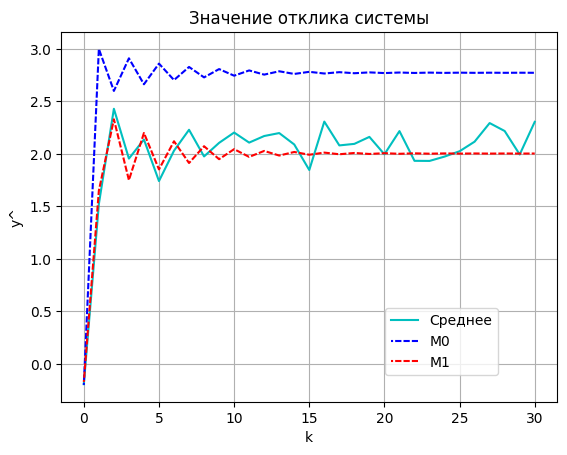

In [328]:
_x = list(range(len(Y_mean_obs)))
plt.close('all')
fig, ax = plt.subplots()
plt.title("Значение отклика системы")
ax.set_ylabel("y^")
ax.set_xlabel("k")
ax.grid(True)
ax.plot(_x, Y_mean_obs, color='c', linestyle='-', label='Среднее')
ax.plot(_x, Y_est_m0, color='b', linestyle=(2, (3, 1)), label='M0')
ax.plot(_x, Y_est_m1, color='r', linestyle=(2, (3, 1)), label='M1')
fig.legend(loc="upper left", bbox_to_anchor=(0.62,0.32))

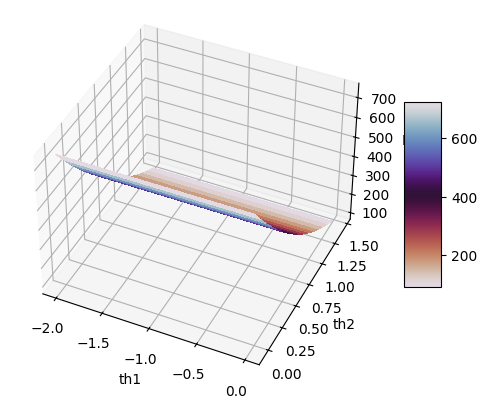

In [329]:
Y_true = gen_XY(th_true, 0, 0)[1]
#%matplotlib widget
step = 0.1
th1a = np.arange(-2, 0.01, step)
th2a = np.arange(-0.05, 1.499, step)
th1, th2 = np.meshgrid(th1a, th2a)
ci = np.array([[Hi(np.array([th1_, th2_]), Y_true) for th1_, th2_ in zip(a,b)] for a,b in zip(th1, th2)])
ci = ci.reshape(16, 21)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(th1, th2, ci, cmap=cm.twilight_r, linewidth=0, antialiased=False)
ax.view_init(40, 295);
ax.set_xlabel('th1')
ax.set_ylabel('th2')
ax.set_zlabel('HI')
fig.colorbar(surf, shrink=0.5, aspect=5);

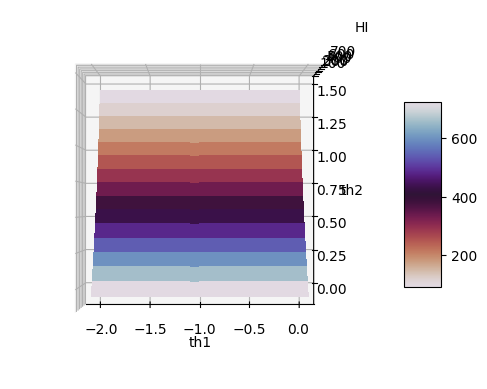

In [330]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(th1, th2, ci, cmap=cm.twilight_r, linewidth=0, antialiased=False)
ax.view_init(89.5, -90);
ax.set_xlabel('th1')
ax.set_ylabel('th2')
ax.set_zlabel('HI')
fig.colorbar(surf, shrink=0.5, aspect=5);